In [2]:
# import libraries
import torch
import numpy as np

## Load and analyze the data

### Load the data and create dataloaders

source: http://pytorch.org/docs/stable/torchvision/datasets.html

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

# download the training and testing datasets
# transform then to tensors
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
from sklearn.model_selection import train_test_split

# split train dataset in train and validation datasets
# probably SubsetRandomSampler is a better way
train_dataset, valid_dataset = train_test_split(train_dataset, train_size=0.8, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# batch size
batch_size = 20

# prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # only train should be shuffled
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'{len(train_loader.sampler)} samples for training.')
print(f'{len(valid_loader.sampler)} samples for evaluation.')
print(f'{len(test_loader.sampler)} samples for testing.')

48000 samples for training.
12000 samples for evaluation.
10000 samples for testing.


### Analyze the data

This repository is already processed and we do not have to take care so we are just going to take a look and visualize a Batch of the data.

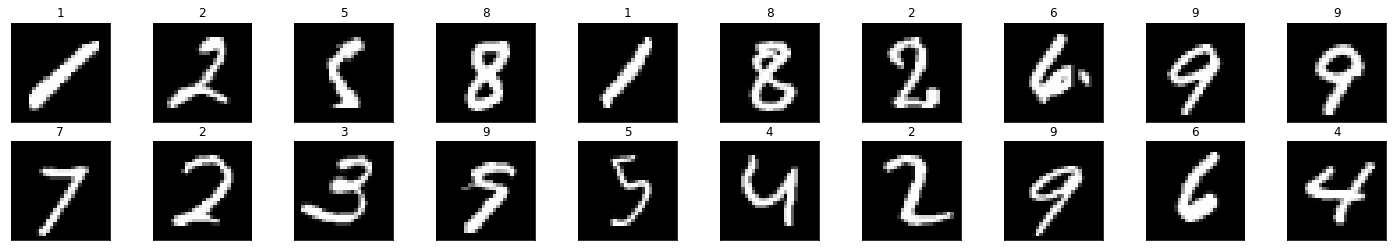

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# get one batch of the training images and plot them
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()), color=('black'))

## Network Architecture

The input is going to be an image (28x28x1) and the output must be a classification in 10 classes (0-9). The number and the size of the hidden layers can be variable.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, *hiden_layers):
        super().__init__()
        
        layers = []
        last_dim = input_dim
                
        for idx, dim in enumerate(hiden_layers):
            layers.append(nn.Linear(last_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            last_dim = dim
            
        layers.append(nn.Linear(last_dim, output_dim))
        
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input, the -1 is like a wild card
        x = x.view(-1, 28 * 28)
        # pass though the network
        x = self.fc(x)
        return x

In [8]:
# create the network with 2 hidden layers of 250 neurons each one
model = Net(28*28*1, 10, 250, 250)
print(model)

Net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=250, out_features=10, bias=True)
  )
)


###  Loss Function and Optimizer

Cross-entropy loss is a good start for classification (notice that softmax is not applied after the last fully connected layer in order to get the digits and no the probabilities) and the use of Adam optimizer for this kind of problems is quite standard.

In [9]:
# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()

# adam optimizer
optimizer = torch.optim.Adam(model.parameters())

## Train

In [10]:
# this function checks if GPU is available, if it is we will use to train the model
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
get_device()

device(type='cuda')

In [11]:
# this function trains the model for one epoch
def train(model, dataloader, optimizer, loss_fn):
    # check if GPU is available, if it is use it
    device = get_device()
    # pass the model to the device and put it in training mode
    model.to(device)
    model.train()
    # initialize the loss
    total_loss = 0.0
    # for every batch
    for batch_idx, (data, target) in enumerate(dataloader):
        # use GPU if available
        data, target = data.to(device), target.to(device)
        # restart the gradient
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = loss_fn(output, target)
        # back propagation
        loss.backward()
        optimizer.step()
        # update the loss
        total_loss += loss.item()*len(data)
    return total_loss/len(dataloader.dataset)

In [12]:
# this function evaluate the performance of the model
def test(model, dataloader, loss_fn):
    # check if GPU is available, if it is use it
    device = get_device()
    # pass the model to the device and put it in evaluation mode
    model.to(device)
    model.eval()
    # initialize the loss and the count of correct predictions
    total_loss = 0.0
    correct = 0
    # not need of gradients for test (it may save some time and/or memory)
    with torch.no_grad():
        # for every batch
        for batch_idx, (data, target) in enumerate(dataloader):
            # use GPU if available
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # update the loss
            total_loss += loss.item()*len(data)
            # it is nice to hace the accuracy as well
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the maximum
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss/len(dataloader.dataset), correct/len(dataloader.dataset)

In [13]:
# number of epochs
n_epochs = 10

# we will keep track of the minimum validation loss achived and use it to save or not the model
valid_loss_min = float('INF')
# train the model for n_epochs epochs
for epoch in range(n_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_acc = test(model, valid_loader, loss_fn)
    print(f'Epoch {epoch+1}/{n_epochs}\t\tTraining loss {train_loss:.4f}\t\tValidation loss {valid_loss:.4f}\t\tValidation accuracy {valid_acc:.4f}')
    
    # save model only if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Saving model...')
        torch.save({'model': str(model), 'state_dict': model.state_dict()}, 'model.pt')
        valid_loss_min = valid_loss

Epoch 1/10		Training loss 0.3900		Validation loss 0.1578		Validation accuracy 0.9524
Saving model...
Epoch 2/10		Training loss 0.2154		Validation loss 0.1220		Validation accuracy 0.9628
Saving model...
Epoch 3/10		Training loss 0.1834		Validation loss 0.1262		Validation accuracy 0.9643
Epoch 4/10		Training loss 0.1660		Validation loss 0.0980		Validation accuracy 0.9712
Saving model...
Epoch 5/10		Training loss 0.1533		Validation loss 0.0957		Validation accuracy 0.9708
Saving model...
Epoch 6/10		Training loss 0.1475		Validation loss 0.0880		Validation accuracy 0.9726
Saving model...
Epoch 7/10		Training loss 0.1386		Validation loss 0.0873		Validation accuracy 0.9746
Saving model...
Epoch 8/10		Training loss 0.1361		Validation loss 0.0856		Validation accuracy 0.9758
Saving model...
Epoch 9/10		Training loss 0.1274		Validation loss 0.0854		Validation accuracy 0.9751
Saving model...
Epoch 10/10		Training loss 0.1219		Validation loss 0.0867		Validation accuracy 0.9749


###  Load "the best" Model

In [14]:
saved = torch.load('model.pt')
model.load_state_dict(saved['state_dict'], strict=False) # strict false allow us to partially load a model or load a partial model
print('Saved model architecture:')
print(saved['model'])
print('-------------------------------------')
print('Current model architecture:')
print(saved['model'])

Saved model architecture:
Net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=250, out_features=10, bias=True)
  )
)
-------------------------------------
Current model architecture:
Net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=250, out_features=10, bias=True)
  )
)


## Test

Testing should always be performed on unseen data. It is possible to do a more detailed analysis, for example testing the performance of the model in each class.

In [15]:
# we can use the same function than before
test_loss, test_acc = test(model, test_loader, loss_fn)
print(f'Test loss {test_loss:.4f}\t\tTest accuracy {test_acc:.4f}')

Test loss 0.0868		Test accuracy 0.9763


### Visualize Results

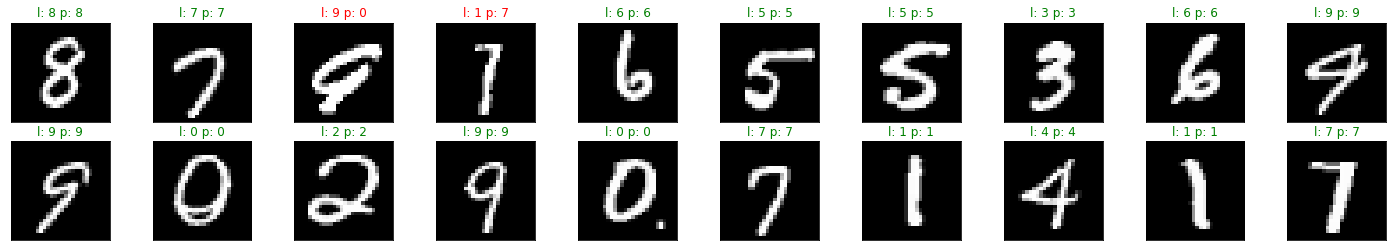

In [16]:
# test is not as heavy computation as training so we use the CPU
model.cpu()

# get one batch of the training images and plot them
images, labels = iter(train_loader).next()
# forward pass
output = model(images)
# get the maximum "probability" of each prediction and remove single-dimensional entries
predictions = output.argmax(dim=1, keepdim=True).squeeze()
# convert images to plot them
images = images.numpy()

# plots
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f'l: {labels[idx].item()} p: {predictions[idx].item()}', color=("green" if predictions[idx]==labels[idx] else "red"))